# Simulated base inference of SEEG signals using 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

from numpy import linalg as LA

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import pystan

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [5]:
cwd = os.getcwd()
cwd

'/data/BVEP_SEEG'

In [6]:
Res_dir='data_output_files'

### Constants

In [7]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [8]:
cwd = os.getcwd()
cwd

'/data/BVEP_SEEG'

## Structural Connectivity and Gain Matrices

In [9]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData", "weights.txt"))

In [10]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [11]:
weights.min(), weights.max()

(0.0, 1.0)

In [12]:
Gr = np.loadtxt(os.path.join(cwd+"/ExperimentalData", "gain_inv-square.txt"))

In [13]:
Gr.max(), Gr.min()

(149.33196109768377, 0.02149773149524995)

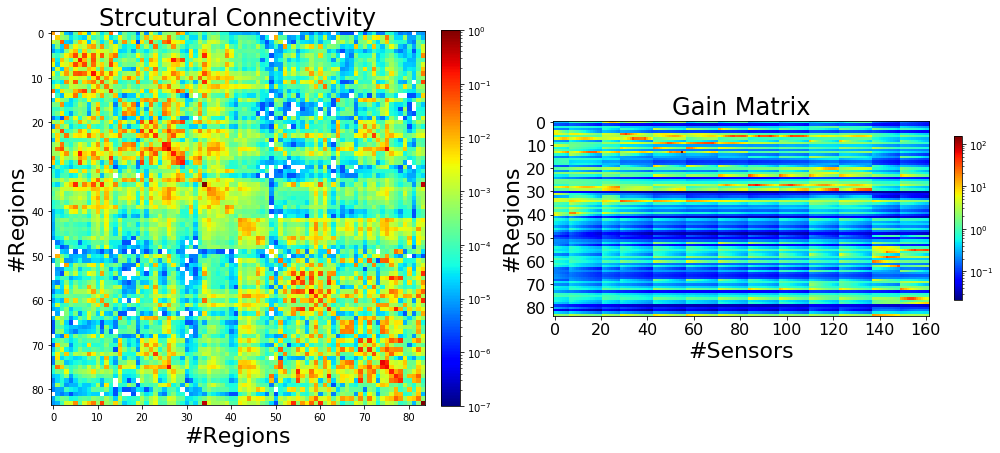

In [14]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.subplot(122)
norm = colors.LogNorm(Gr.min(), Gr.max())
im = plt.imshow(Gr.transpose(),norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.02, pad=0.06)
plt.gca().set_title('Gain Matrix', fontsize=24.0)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Sensors', fontsize=22.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SC_GainMatrix.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SC_GainMatrix.eps"), doi=800)
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [15]:
hz_val=-3.5 
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [16]:
#Here, confidential medical information

In [17]:
SC=weights
SC.shape

(84, 84)

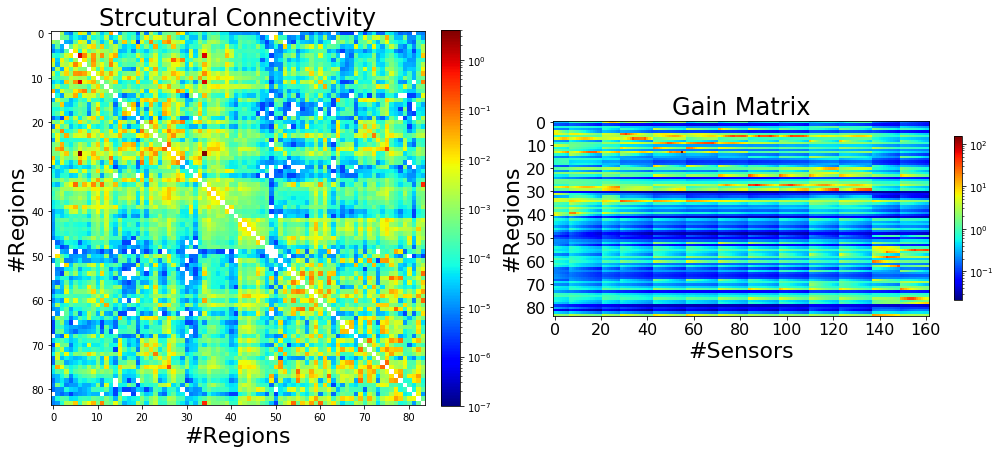

In [18]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
norm = colors.LogNorm(1e-7, SC.max())
im = plt.imshow(SC,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.subplot(122)
norm = colors.LogNorm(Gr.min(), Gr.max())
im = plt.imshow(Gr.transpose(),norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.02, pad=0.06)
plt.gca().set_title('Gain Matrix', fontsize=24.0)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Sensors', fontsize=22.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SCmodified_GainMatrix.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SCmodified_GainMatrix.eps"), doi=800)
plt.show()

### Selected nodes and contacts

In [19]:
contacts = []
with open(cwd+ '/ExperimentalData/complex_raw.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx)) 

In [20]:
reg_xyz = np.loadtxt(cwd+ '/ExperimentalData/centers.txt', usecols=(1,2,3))

reg_names = []
with open(cwd+ '/ExperimentalData/centers.txt', 'r') as fd:
    #for line in fd.readlines():
     #   reg_names.append(line.strip().split()[0])
    for i, line in enumerate(fd.readlines()):
        reg_names.append('r%03d-%s' % (i, line.strip().split()[0]))
#seg = nibabel.load('aparcaseg_2_diff_2.nii.gz')
#reg_xyz = seg.affine.dot(c_[reg_xyz, ones((reg_xyz.shape[0], ))].T)[:3].T

In [21]:
seeg_xyz = np.loadtxt(cwd+ '/ExperimentalData/elecs_name.txt', usecols=(1,2,3))

seeg_labels = []

with open(cwd+ '/ExperimentalData/elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
#print sorted(seeg_labels+[e+str(i) for e, i in contacts])
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = np.array([seeg_xyz[i] for i in monopolar_chan_to_pos])

In [22]:
ez_idx, pz_idx

(array([ 6, 34], dtype=int32), array([27,  5, 11], dtype=int32))

In [23]:
selectednodes=np.array([ 5,  6,  11,  27, 34])
r_selectednodes=reg_xyz[selectednodes]

Ps=np.array([] ) 

selectedcontacts=[bipnames[c] for c in Ps]

ss=[]
sss=[]
for s in selectedcontacts:
    parts = s.strip().split('-')
    name, idx=re.match("([A-Za-z]+[']*)([0-9]+)", s).groups()
    idx = int(idx)
    #sss.append((name, idx))
    ss.append(parts[0].upper())
    
    
selectedcontacts_indices=[contacts_labels.index(c) for c in ss] 
r_selectedcontacts=seeg_xyz[selectedcontacts_indices]


In [24]:
def plot_selected_nodes():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(ra, rb, color='k', s=50)
        plt.scatter(sa, sb ,color='b',marker='^', s=5 )
    x, y, z = zip(r_selectednodes.T, r_selectedcontacts.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(ra, rb,color='r', s=50)
        plt.scatter(sa, sb, color='r',marker='^', s=20)
        plt.axis([-120, 100, -120, 100])
        #xticks([]), yticks([])

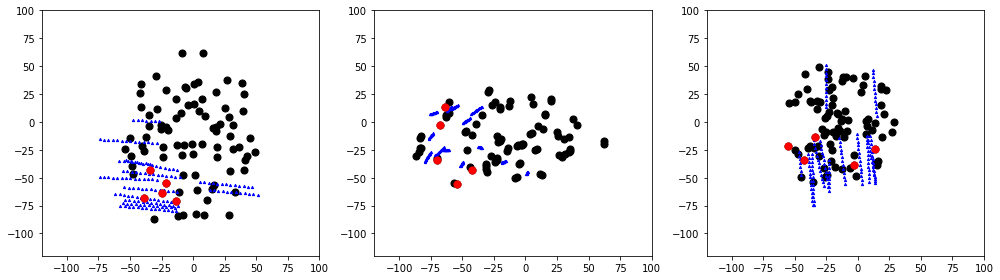

In [25]:
plt.figure(figsize=(14, 4))
plot_selected_nodes()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SelectedNodesandElectrodes.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SelectedNodesandElectrodes.eps"), doi=800)
plt.show()

In [26]:
nn=reg_xyz.shape[0]
ns=seeg_xyz.shape[0]

nn, ns

(84, 162)

In [27]:
dst=np.zeros((nn, ns))

In [28]:
from scipy.spatial import distance
for i in range(0, nn):
    for j in range(0, ns):
        dst[i,j] = distance.euclidean(reg_xyz[i,: ], seeg_xyz[j,: ])

In [29]:
dist_best=np.min(dst, axis=1)

In [30]:
dist_best.shape

(84,)

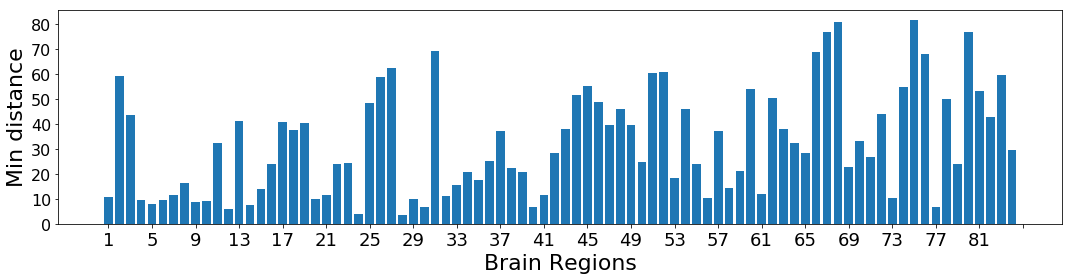

In [31]:
plt.figure(figsize=(15, 4))
plt.bar(np.r_[0:nn], dist_best)
plt.ylabel('Min distance',fontsize=22)
plt.xlabel('Brain Regions',fontsize=22)
plt.xticks(np.arange(0,nn+2, step=4),np.arange(1, nn+1, step=4), fontsize=18, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"NodesDistances.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"NodesDistances.eps"), doi=800)
plt.show()

In [32]:
elecnames=[]
electrodes = {}  
with open(cwd+ '/ExperimentalData/elecs_name.txt', 'r') as fd:
            for i, line in enumerate(fd.readlines()):
                line = line.strip()
                contact, x, y, z = line.split()
                elecnames.append(contact)
                name, _ = re.match("([A-Za-z]+[']*)([0-9]+)", contact).groups()
                if name in electrodes:
                    electrodes[name].append(i)
                else:
                    electrodes[name] = [i]

In [33]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

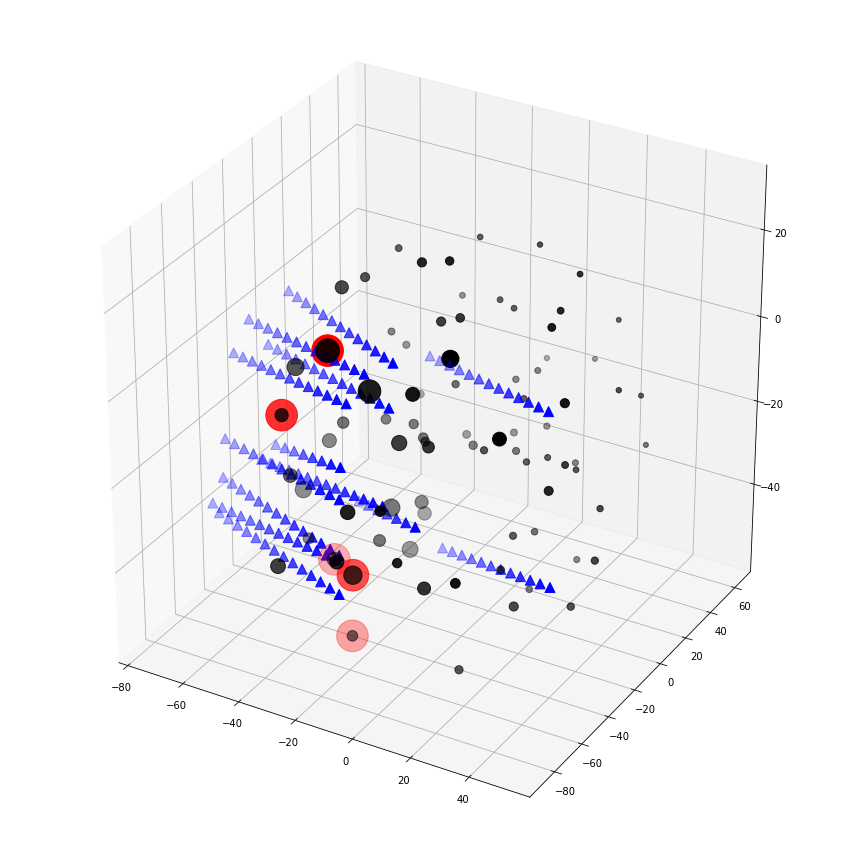

In [34]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color='k', s=2000./dist_best,  label='regions')
ax.scatter(r_selectednodes [:, 0], r_selectednodes [:, 1], r_selectednodes [:, 2], color='r', s=1000, label='selectedregions')
ax.scatter(r_selectedcontacts [:, 0], r_selectedcontacts [:, 1], r_selectedcontacts [:, 2], color='cyan',marker='^', s=300, label='selectecontacts')


for name, idxs in electrodes.items():
    ax.scatter(seeg_xyz [idxs, 0], seeg_xyz [idxs, 1], seeg_xyz [idxs, 2],marker='^', color='b', s=100, label=name)
    

#plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SelectedNodesandElectrodes3D.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SelectedNodesandElectrodes3D.eps"), doi=800)
#ax.view_init(-390, 30)

plt.show()    

### Simulator

In [35]:
#from BVEP_Simulator import VEP2Dmodel

In [36]:
@jit(nopython=True) 
def epileptor2D_sde_fn(y, dt, sigma,  eta, tau, K, SC):
    nn = SC.shape[0]
    x = y[0:nn]
    z = y[nn:2*nn]
    I1 = 3.1
    gx = np.sum(K * SC * (np.expand_dims(x, axis=0) - np.expand_dims(x, axis=1)), axis=1)
    dx = 1.0 - np.power(x, 3) - 2 * np.power(x, 2) - z + I1 + np.sqrt(dt)*sigma*np.random.randn()
    dz = (1.0/tau)*(4*(x - eta) - z - gx) + np.sqrt(dt)*sigma*np.random.randn()
    return np.concatenate((dx, dz))

In [37]:
@jit(nopython=True) 
def Integrator_Euler(y_init, nt, dt, sigma, eta, tau, K, SC):
    nn = SC.shape[0]
    y_out = np.zeros((2*nn, nt))
    y_next = y_init
    h = dt
    for i in np.arange(nt):
            k1 = epileptor2D_sde_fn(y_next, dt, sigma, eta, tau, K, SC)
            y_next = y_next + (h) * (k1)
            y_out[:,i] =  y_next 
    return y_out    

In [38]:
@jit(nopython=True) 
def VEP2Dmodel(params, constants, init_conditions, dt, ts, SC):
    
    nt=ts.shape[0]
    nn=SC.shape[0]
    
    #parameters
    eta=params[0:nn]
    K=params[-1]
    

    # fixed parameters
    tau=constants[0]
    sigma=constants[1]

    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage
    
    # initial conditions
    x_init, z_init=init_conditions[0]*np.ones(nn), init_conditions[1]*np.ones(nn)
    
    y_init =np.concatenate((x_init, z_init), axis=0)

    y_euler = Integrator_Euler(y_init, nt, dt, sigma, eta, tau, K, SC)

    x=y_euler[0:nn,]
    z=y_euler[nn:2*nn,]

    return np.concatenate((x.reshape(-1) , z.reshape(-1) )) 

### some simulations for  sanity check

In [39]:
T = 30.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [40]:
nt=ts.shape[0]
nt

301

In [41]:
nn=SC.shape[0]
nn

84

In [42]:
Gr.shape

(162, 84)

In [43]:
ns=Gr.shape[0]
ns

162

In [44]:
tau=10.
sigma=0*10e-1
constants = np.array([tau, sigma])
constants

array([10.,  0.])

In [45]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [46]:
K_true=1.

In [47]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [48]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [49]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 4.466256618499756


In [50]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.006865024566650391


In [51]:
Sim.shape

(50568,)

In [52]:
Sim_source=Sim.reshape(nn, int(Sim.shape[0]/(nn)))
Sim_source.shape

(84, 602)

In [53]:
X=Sim[0:nn*nt].reshape(nn, nt)
Z=Sim[nn*nt:2*nn*nt].reshape(nn, nt)

In [54]:
X.shape, Z.shape

((84, 301), (84, 301))

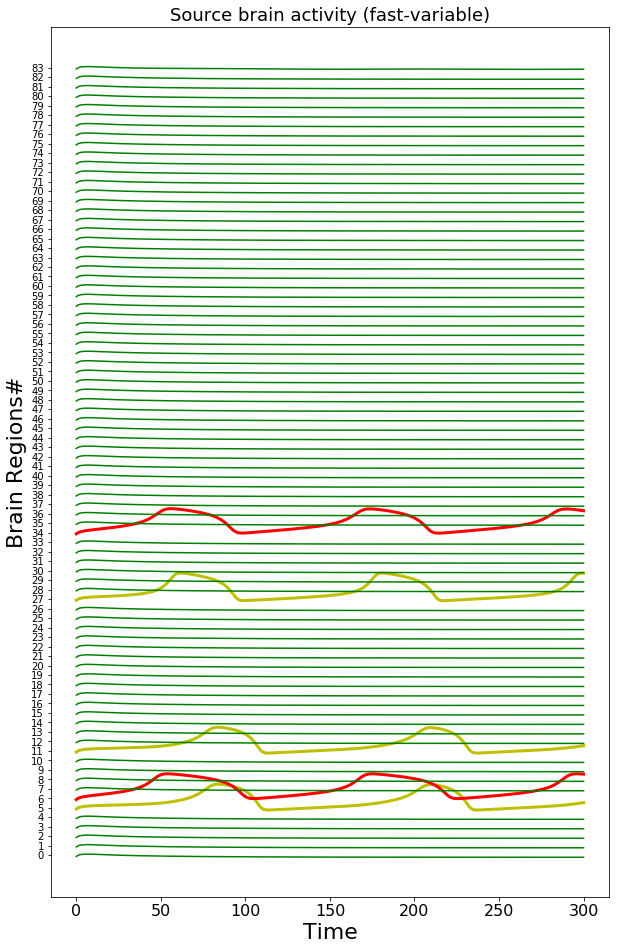

In [55]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

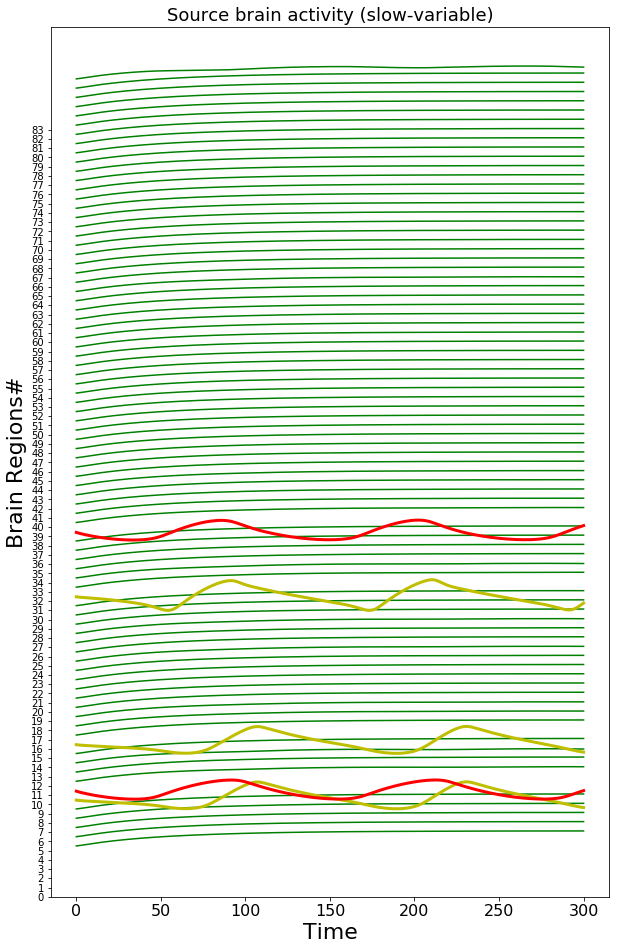

In [56]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(Z[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(Z[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(Z[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (slow-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

### Seeg signal

In [57]:
nn, ns, nt

(84, 162, 301)

In [58]:
X.shape, Gr.shape

((84, 301), (162, 84))

In [59]:
Seeg= np.dot(Gr, X)+3*np.random.randn(ns,nt)
Seeg.shape

(162, 301)

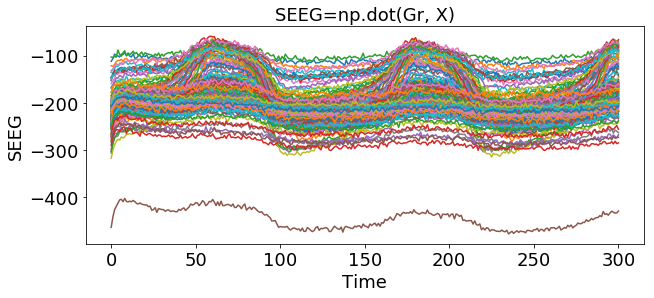

In [60]:
plt.figure(figsize=(10,4))
plt.plot(Seeg.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, X)",fontsize=18)
plt.show()

In [61]:
cut_in=120
cut_fn=250

In [62]:
Seeg_env=Seeg[:,cut_in:cut_fn]
Seeg_env.shape

(162, 130)

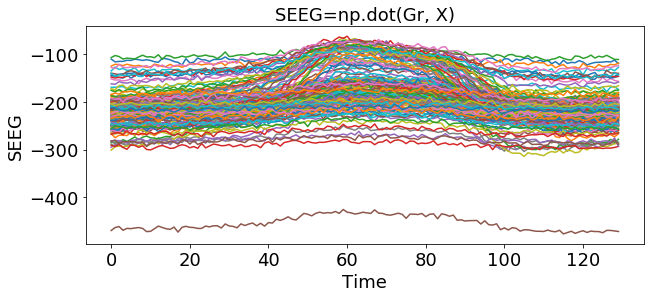

In [63]:
plt.figure(figsize=(10,4))
plt.plot(Seeg_env.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, X)",fontsize=18)
plt.show()

In [64]:
offset_mean=10.
offset_std=1.

In [65]:
offset=offset_mean+offset_std*np.random.randn(ns,1)
offset.shape

(162, 1)

In [66]:
Seeg_env.shape, offset.shape

((162, 130), (162, 1))

In [67]:
nt=Seeg_env.shape[1]

In [68]:
nn, ns, nt

(84, 162, 130)

In [69]:
Obs_seeg=np.zeros((ns,nt))

In [70]:
Obs_seeg[:,0:nt]=Seeg_env[:,0:nt]+offset

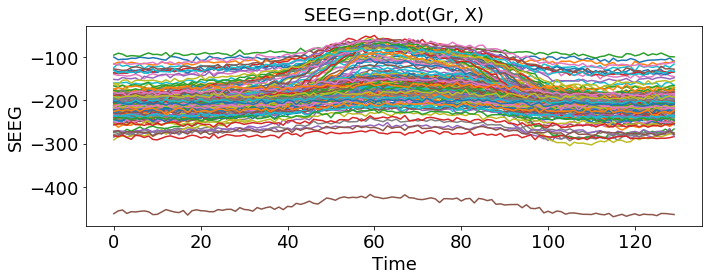

In [71]:
plt.figure(figsize=(10,4))
plt.plot(Obs_seeg.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, X)",fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Simulated_SEEG_env.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Simulated_SEEG_env.eps"), doi=800)
plt.show()

In [72]:
X.shape, Z.shape

((84, 301), (84, 301))

In [73]:
x_source=X[:,cut_in:cut_fn]
z_source=Z[:,cut_in:cut_fn]
ts=ts[cut_in:cut_fn]

In [74]:
x_source.shape

(84, 130)

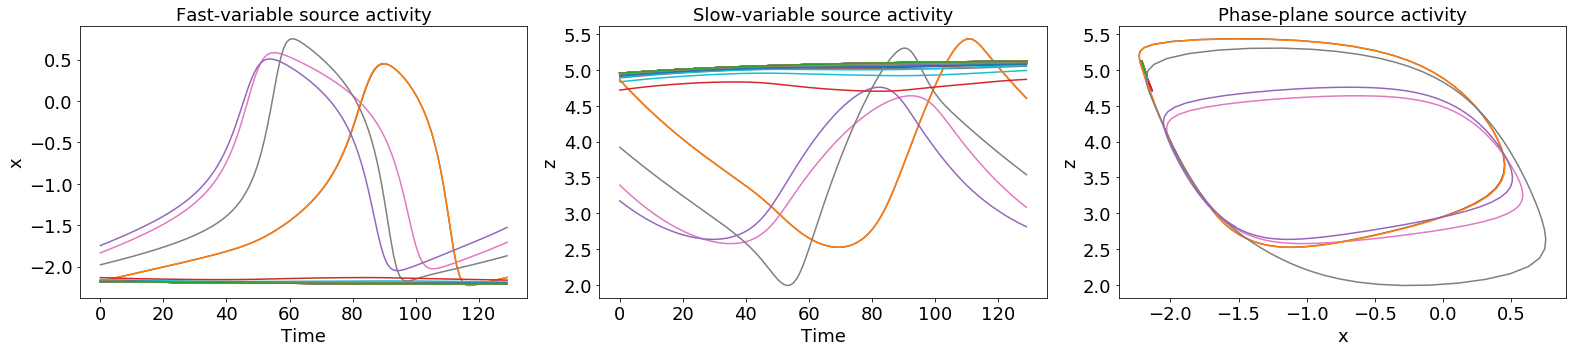

In [75]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(x_source.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('x',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Fast-variable source activity",fontsize=18)

plt.subplot(132)
plt.plot(z_source.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Slow-variable source activity",fontsize=18)


plt.subplot(133)
plt.plot(x_source.T, z_source.T);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Phase-plane source activity",fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Simulated_source_activity.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Simulated_source_activity.eps"), doi=800)
plt.show()

In [76]:
Obs_seeg.shape, x_source.shape, z_source.shape

((162, 130), (84, 130), (84, 130))

### Seeg features

In [77]:
Obs_seeg.shape, Gr.shape

((162, 130), (162, 84))

In [78]:
Seeg_area = np.trapz(Obs_seeg, dx=0.0001)
Seeg_area.shape

(162,)

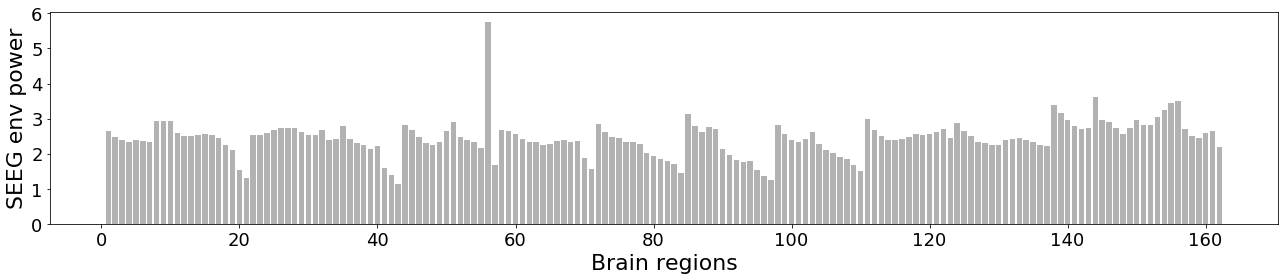

In [79]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_area.shape[0]+1), -Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('SEEG env power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SEEG_envelop_power.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SEEG_envelop_power.eps"), doi=800)
plt.show()

In [80]:
Seeg_pwr = np.sum((Seeg*Seeg), axis=1)
Seeg_pwr_n = (Seeg_pwr/ Seeg_pwr.max())

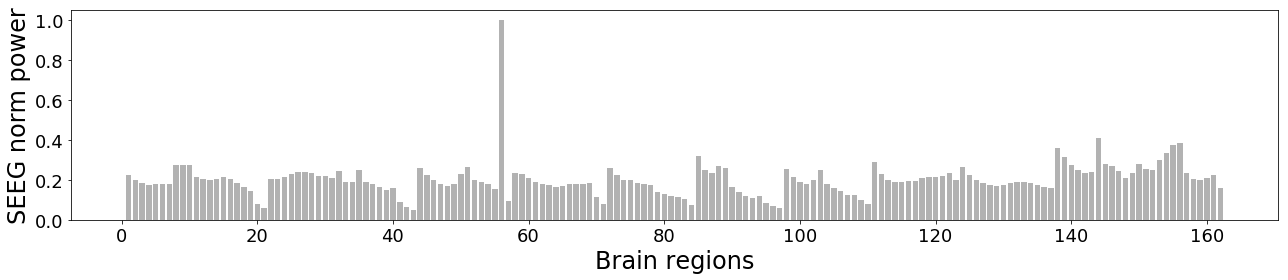

In [81]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_pwr.shape[0]+1), Seeg_pwr_n, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=24)
plt.ylabel('SEEG norm power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SEEG_envelop_power_normalize.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"SEEG_envelop_power_normalize.eps"), doi=800)
plt.show()

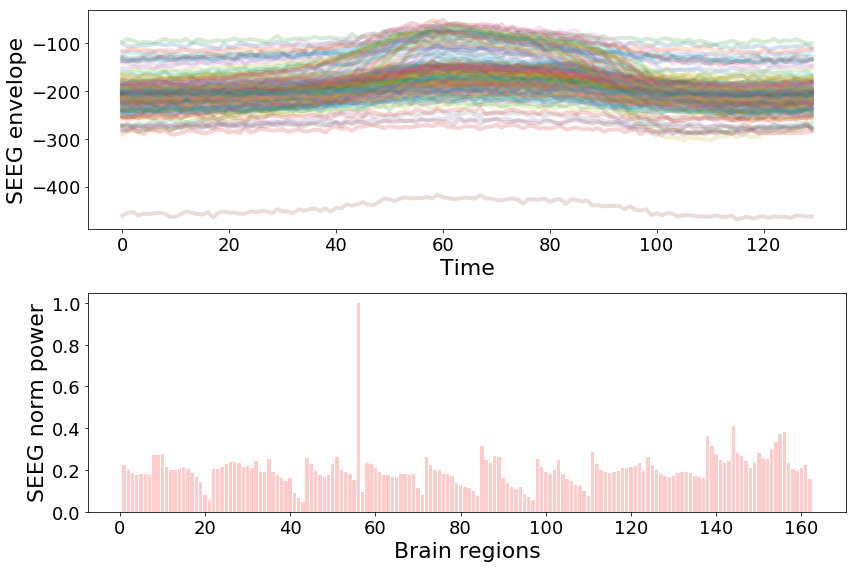

In [82]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(Obs_seeg.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG envelope', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(212)
plt.bar(np.arange(1,Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='r', alpha=0.2)
#plt.bar(np.arange(1,Seeg_area.shape[0]+1), Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('SEEG norm power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEG.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEG.eps"), doi=800)
plt.show()

In [83]:
Gr.shape

(162, 84)

In [84]:
GtG=np.dot(Gr.T, Gr)
GtG.shape

(84, 84)

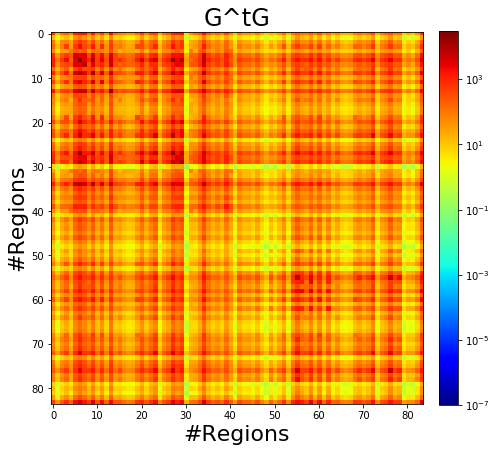

In [85]:
plt.figure(figsize=(7, 8))
norm = colors.LogNorm(1e-7, GtG.max())
im = plt.imshow(GtG,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('G^tG', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"GTGMatrix.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"GTGMatrix.eps"), doi=800)
plt.show()

In [86]:
w, v = LA.eig(GtG)

In [87]:
v.shape

(84, 84)

### save data input

In [88]:
Obs_seeg.shape, x_source.shape, z_source.shape

((162, 130), (84, 130), (84, 130))

In [89]:
nn, ns, nt,

(84, 162, 130)

In [90]:
ts.shape, dt

((130,), 0.1)

In [91]:
SC.shape, Gr.shape, K_true, 

((84, 84), (162, 84), 1.0)

In [92]:
data_iput_filename=str('datainput_Seeg_84nodes_patient1')

In [93]:
data_iput_dict= {
    'nn': nn, 'ns': ns, 'nt': nt, 'dt': dt, 'ts': ts, 't0': ts[0],
    'SC': SC, 'Gr': Gr, 'Ks': K_true, 'tau0': tau, 'I1': I1, 'eigen_vec': v, 
    'Obs_seeg': Obs_seeg.T, 'x_source': x_source.T, 'z_source': z_source.T,
    'ez_idx': ez_idx, 'pz_idx': pz_idx, 'ez_val': ez_val, 'pz_val': pz_val, 'hz_val': hz_val, 
    'xlim': np.r_[-5.0, 5.0],'zlim': np.r_[0.0, 10.0],
}

In [94]:
nd=[]
npz = {'nd': nd}
npz.update(data_iput_dict)
np.savez(cwd+'/data_input_files/'+ str(data_iput_filename) +'.R.npz', **npz)
np.savez(cwd+'/data_input_files/'+ str(data_iput_filename) +'.npz', **npz)
pystan.stan_rdump(data_iput_dict, cwd+'/data_input_files/' + str(data_iput_filename)+ '.R')